<a href="https://colab.research.google.com/github/sa96102/Python_exam/blob/master/Semantic_segmentation_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

### Download Model(DeepLabV3)

In [3]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval() # pretrained를 True로 해야 weight값을 받아옴. model.eval()_모델을 테스트 모드로 전환.

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


### Create Palette

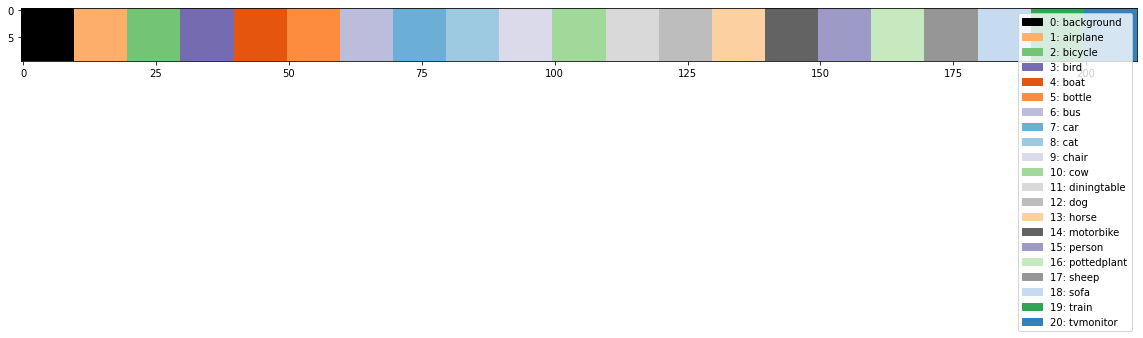

In [4]:
labels = ['background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)

palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(20, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)

### Segment Function

In [0]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]) # torchvision.transform()_이미지 전처리 모듈. transforms.ToTensor()_이미지를 텐서로 변환. transforms.Normalize()_이미지 정규화.

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # tensor.unsqueeze()_텐서에 차원(새로운 축)을 추가. squeeze의 반대. 여기서는 image tensor (3, 세로, 가로) 형태로 나온 것을 모델에 넣을 때는 batch 단위로 넣어야 하므로 (1, 3, 세로, 가로)로 바꿈.

    if torch.cuda.is_available(): # torch.cuda.is_available()_cuda를 사용할 수 있다면 True를 반환.
        input_batch = input_batch.to('cuda')
        model.to('cuda') # model(or batch).to('cuda')_model 또는 batch를 cuda로 이동하여 처리.

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) argmax(0)_각 픽셀의 채널 방향으로 최소값의 채널 인덱스 반환. byte()_uint8 타입으로 변환. cpu()_cuda에서 CPU로 이동. numpy()_tensor를 numpy ndarray로 변환.

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0])) # Image.fromarray()_numpy ndarray를 Pillow Image 타입으로 변환.
    r.putpalette(colors) # palette 적용.

    return r, output_predictions

### Segmentation Result

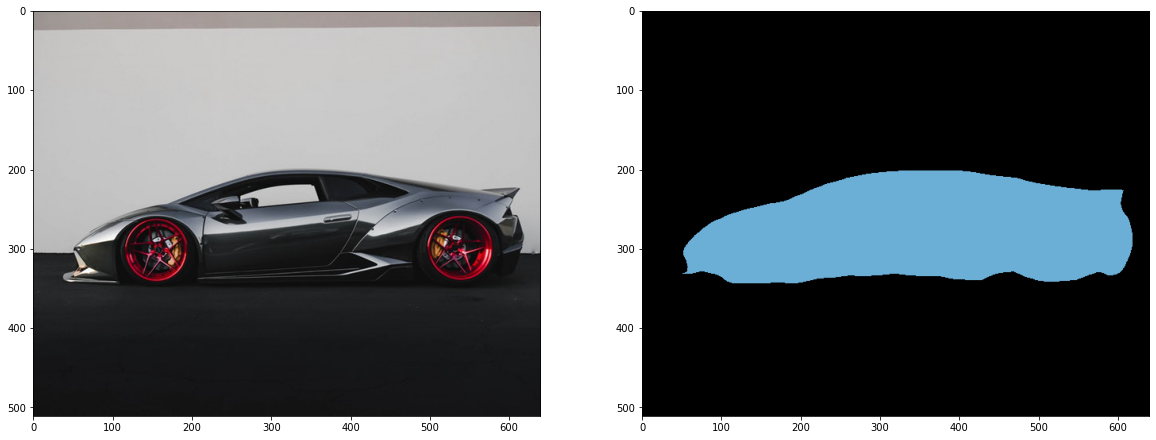

In [6]:
img = np.array(Image.open('/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Semantic segmentation/01.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

### Load Background Image and Resize

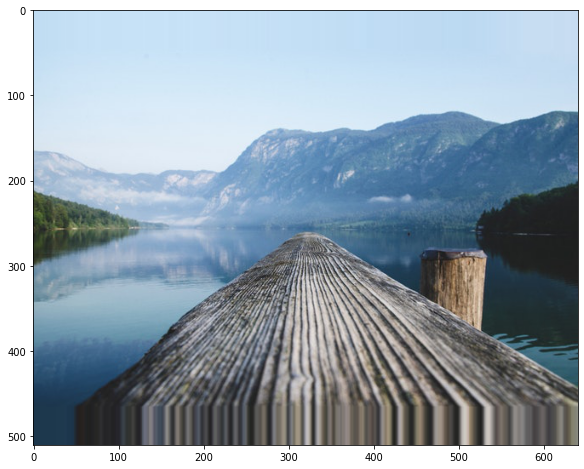

In [10]:
background = np.array(Image.open('/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Semantic segmentation/bg01.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0: # 배경의 세로 크기 조절.
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)
    # cv2.copyMakeBorder()_이미지에 경계선을 만들거나 픽셀을 복사해 이미지의 크기 늘림.

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

### Separate Foreground and Background

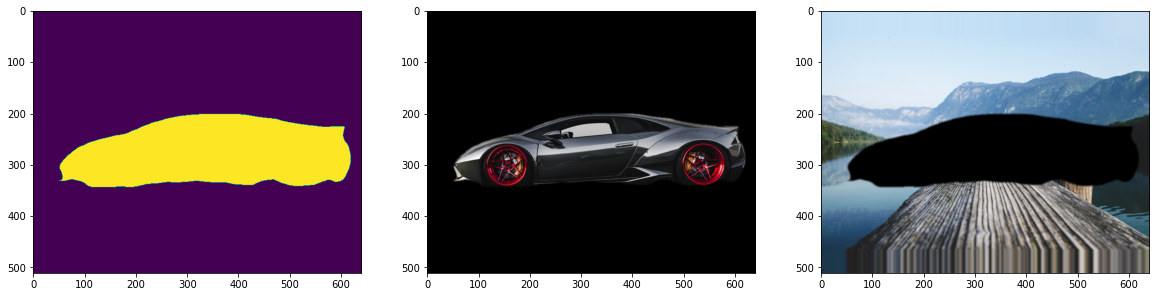

In [11]:
mask = (pred == 7).astype(float) * 255 # 15: car pred_segmentation 결과에서 argmax까지만 한 결과.
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY) # cv2.threshold()_임계값 처리로 바이너리 마스크를 만듦.

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float) # cv2.GaussianBlur()_이미지를 흐릿하게 만듦.

alpha = alpha / 255. # (height, width) cv2.multiply() 또는 cv2.add()를 사용하려면 alpha와 img의 shape가 같아야 함.
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)
# np.expand_dims()_차원(축)을 추가. np.repeat()_배열 값을 반복하여 복사.

foreground = cv2.multiply(alpha, img.astype(float)) # cv2.multiply()_element-wise 곱
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

### Result

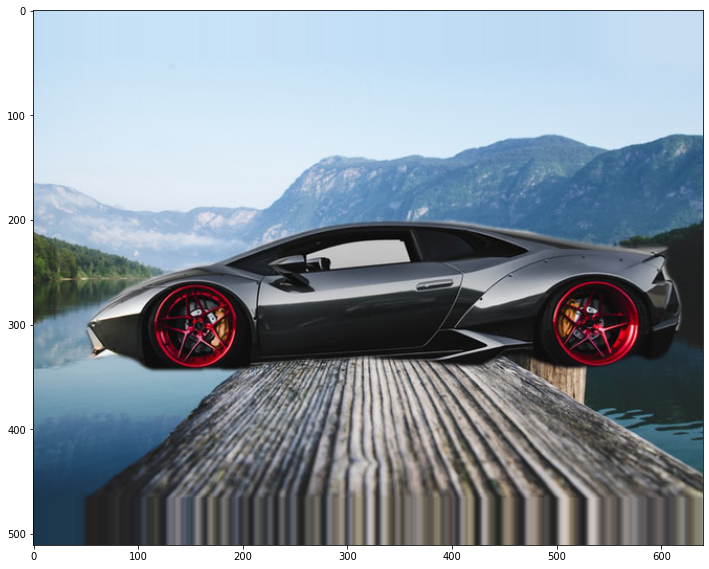

In [12]:
result = cv2.add(foreground, background).astype(np.uint8) # cv2.add()_element-wise 합

Image.fromarray(result).save('result.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(result)

### Background Blur

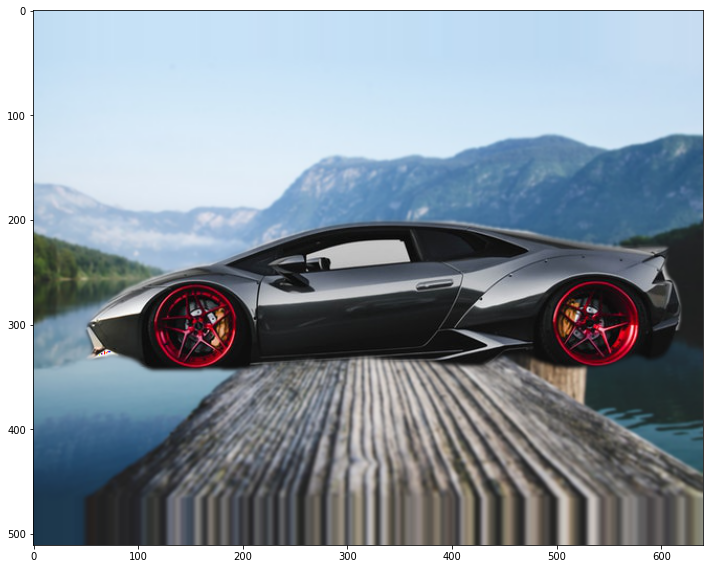

In [13]:
blurred_background = cv2.GaussianBlur(background, (5, 5), 0).astype(float)

bluured_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(bluured_result).save('result_bb.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(bluured_result)

### Background Grayscale

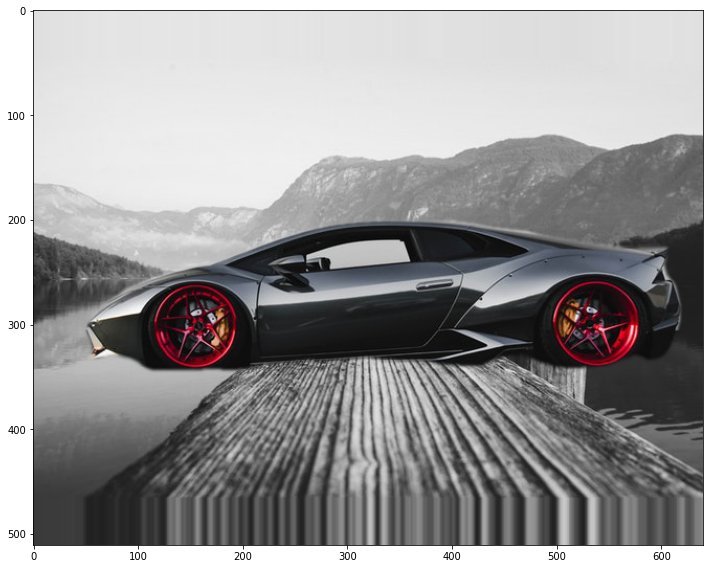

In [16]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float)

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

Image.fromarray(gray_result).save('result_bg.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(gray_result)